In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 14a

## Working with Tensorflow 
- One hidden layer
- ${Swish}$ activation function
- Adam
- Multi-class output
- FIFA dataset

</p><img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
# Lets import some libraries
import os

import sys

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from time import time

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.preprocessing import StandardScaler

import tensorflow as tf

%matplotlib inline

2023-11-27 17:58:39.940401: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 17:58:39.940519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 17:58:39.960234: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 17:58:40.011111: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 17:58:40.962699: W tensorflow/compiler/tf2

In [3]:
# Some basic parameters

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
 
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well


EPOCHS = 100 # number of epochs
ALPHA = 0.1 # learning rate

BATCH_SIZE = 256 # other sizes leave last batch partial

TRAIN_SIZE = int(BATCH_SIZE*64) # to create 64 batches of 256 rows each

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,15),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

### Settings so that Tensorflow can not Hog all the GPU memory

In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2023-11-27 17:58:42.231226: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 17:58:42.333338: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 17:58:42.333596: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Read FIFA 2019 data set

In [5]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [6]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [7]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [8]:
# Are there NaNs Still?

data_df.isna().sum()

Position           0
Finishing          0
HeadingAccuracy    0
ShortPassing       0
Volleys            0
Dribbling          0
Curve              0
FKAccuracy         0
LongPassing        0
BallControl        0
Acceleration       0
SprintSpeed        0
Agility            0
Reactions          0
Balance            0
ShotPower          0
Jumping            0
Stamina            0
Strength           0
LongShots          0
Aggression         0
Interceptions      0
Positioning        0
Vision             0
Penalties          0
Composure          0
Marking            0
StandingTackle     0
SlidingTackle      0
GKDiving           0
GKHandling         0
GKKicking          0
GKPositioning      0
GKReflexes         0
dtype: int64

In [9]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [10]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [11]:
labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [12]:
y = data_df["Position"].values

X = data_df.drop("Position", axis = 1)

In [13]:
# one hot encoding
y = pd.get_dummies(y).values
y

array([[False, False, False,  True],
       [False, False, False,  True],
       [False, False, False,  True],
       ...,
       [False, False, False,  True],
       [False, False, False,  True],
       [False, False,  True, False]])

In [14]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=TRAIN_SIZE,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(16384, 33) (16384, 4) (1763, 33) (1763, 4)


In [15]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [16]:
X_train.shape

(16384, 33)

## Prepare model

Build the `tf.keras.Sequential` model by stacking layers. Choose an optimizer and loss function for training:

In [17]:
# Callig class Sequential and pass all layers as a list
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(18, activation='swish'), # alternatively activation = tf.nn.silu
  tf.keras.layers.Dense(4) # notice absense of softmax function
])

2023-11-27 17:58:42.768480: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 17:58:42.768768: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 17:58:42.768995: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Reference
<p style="font-family: Arial; font-size:1.2em;color:black;">
Details of <a href = "https://www.tensorflow.org/api_docs/python/tf/keras/Sequential">Sequential Model</a>. Sequential provides training and predict features on this model.
</p>

### Functional API

<p style="font-family: Arial; font-size:1.2em;color:black;">You can also instantiate a Model with the <strong>"Functional API"</strong>, where you start from Input, you chain layer calls to specify the model's forward pass, and finally you create your model from inputs and outputs:

>import tensorflow as tf

>inputs = tf.keras.Input(shape=(33,))
    
>x = tf.keras.layers.Dense(18, activation=tf.nn.relu)(inputs)

>outputs = tf.keras.layers.Dense(4, activation=tf.nn.softmax)(x)

>model = tf.keras.Model(inputs=inputs, outputs=outputs)

    
<p style="font-family: Arial; font-size:1.2em;color:black;">You can also extend the model class, if love to live by sword!!
</p>

<p style="font-family: Arial; font-size:1.2em;color:black;">
    For each example the model returns a vector of "logits" or "log-odds" scores, one for each class.
</p>

In [18]:
X_train[:1].shape

(1, 33)

In [19]:
predictions = model(X_train[:1]).numpy()
predictions

2023-11-27 17:58:43.067693: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


array([[-0.7455446 , -0.7449656 ,  0.90757006, -0.32847738]],
      dtype=float32)

In [20]:
predictions.sum()

-0.91141754

The `tf.nn.softmax` function converts these logits to "probabilities" for each class: 

In [21]:
tf.nn.softmax(predictions).numpy()

array([[0.11439937, 0.11446563, 0.59753346, 0.17360155]], dtype=float32)

In [22]:
tf.nn.softmax(predictions).numpy().sum()

1.0

In [23]:
'''
Number of parameters:
    layer 1 : 33*18 +18 = 612 
    layer 2 : 18*4 + 4
We are not locking any layer hence all parameter are trainable    
'''

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 18)                   612       
                                                                 
 dense_1 (Dense)             (1, 4)                    76        
                                                                 
Total params: 688 (2.69 KB)
Trainable params: 688 (2.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Game Changer

`Softmax` function is prone to two issues: overflow and underflow.

- <b>Overflow</b> occurs when very large numbers are being fed.
- <b>Underflow</b> occurs when very small numbers (near zero) are being fed.

There are work arounds too, but, TF has its own approach.<br>
    
Intuition being that every system (32 / 64 bit precision) has limits in terms of largest or smallest value it can accurately process.

It also leads to the vanishing gradient in exponential functions. As you go higher/lower the  will overflow and the gradient will be `zero` irrespective of actually it being a `non-zero`.


Our loss function is crossentropy as there are two or more label classes. The labels are provided using one-hot representation. We will use CategoricalCrossentropy loss. 
    
>y_true = [ [0      1    0], [ 0    1   0 ]<br>
>y_pred = [ [0.05, 0.95, 0], [0.1, 0.1, 0.8] ]


In case, you have not one-hot-encoded use `losses.SparseCategoricalCrossentropy`. It takes a vector of logits and a `True` index and returns a scalar loss for each example.

In [24]:
sys.float_info.max

1.7976931348623157e+308

In [25]:
sys.float_info.min

2.2250738585072014e-308

In [26]:
np.log(sys.float_info.max)

709.782712893384

In [27]:
loss_fn = tf.keras.losses.CategoricalCrossentropy ( from_logits = True)

In [28]:
y_train[:1]

array([[False, False,  True, False]])

In [29]:
loss_fn(y_train[:1], predictions).numpy()

0.51494503

Using `model.compile`, specify the training configuration such as:
- Loss function to minimize
- Optimizer
- List of metrics to monitor

In [30]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

Call `fit()`, which will train the model by slicing the data into `batches` of size `batch_size`, and repeatedly iterating over the entire dataset for a given number of `epochs`. Pass some validation for monitoring validation loss and metrics at the end of each epoch.

In [31]:
history = model.fit(X_train, y_train, 
                    validation_data=[X_test, y_test],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS)

Epoch 1/100


2023-11-27 17:58:43.744241: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f55d4e18b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-27 17:58:43.744268: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-11-27 17:58:43.755522: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-27 17:58:43.783917: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1701088123.846422    8580 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


64/64 [==============================] - 1s 4ms/step - loss: 0.9485 - accuracy: 0.6114 - val_loss: 0.7075 - val_accuracy: 0.7294
Epoch 2/100
64/64 [==============================] - 0s 2ms/step - loss: 0.5915 - accuracy: 0.7770 - val_loss: 0.5122 - val_accuracy: 0.7907
Epoch 3/100
64/64 [==============================] - 0s 2ms/step - loss: 0.4658 - accuracy: 0.8154 - val_loss: 0.4323 - val_accuracy: 0.8157
Epoch 4/100
64/64 [==============================] - 0s 2ms/step - loss: 0.4089 - accuracy: 0.8318 - val_loss: 0.3885 - val_accuracy: 0.8349
Epoch 5/100
64/64 [==============================] - 0s 2ms/step - loss: 0.3748 - accuracy: 0.8450 - val_loss: 0.3611 - val_accuracy: 0.8480
Epoch 6/100
64/64 [==============================] - 0s 2ms/step - loss: 0.3520 - accuracy: 0.8558 - val_loss: 0.3409 - val_accuracy: 0.8537
Epoch 7/100
64/64 [==============================] - 0s 2ms/step - loss: 0.3359 - accuracy: 0.8622 - val_loss: 0.3293 - val_accuracy: 0.8548
Epoch 8/100
64/64 [======

In case we want to separately evaluate this model, we have `evaluate` function.

In [32]:
model.evaluate ( X_test,  y_test, verbose=2)

56/56 - 0s - loss: 0.2873 - accuracy: 0.8837 - 103ms/epoch - 2ms/step


[0.28726083040237427, 0.8837209343910217]

In [33]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.948483,0.611389,0.707550,0.729438
1,0.591456,0.777039,0.512201,0.790698
2,0.465769,0.815369,0.432300,0.815655
3,0.408935,0.831787,0.388549,0.834940
4,0.374794,0.844971,0.361109,0.847986


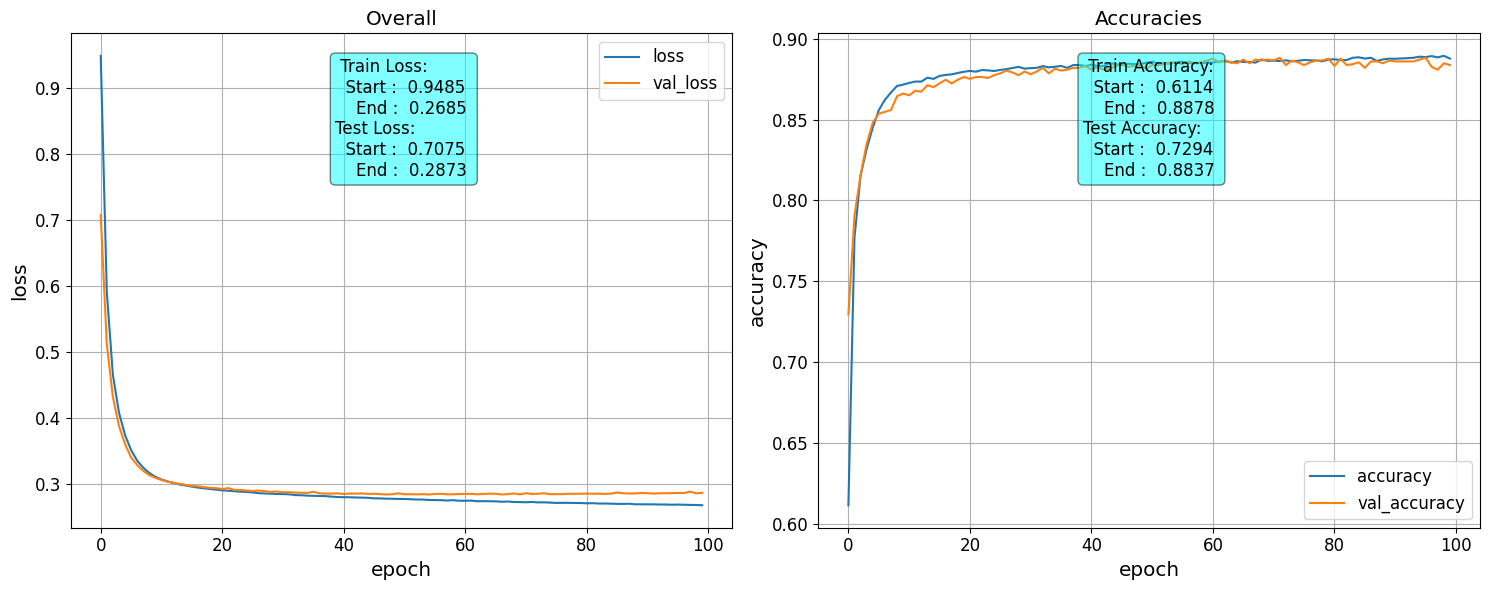

In [43]:
fig, axes = plt.subplots(1,2 , figsize = (15,6),)

l_range = 10 # ignoring first few records
y1_var = 'loss'
y2_var = 'val_loss'

ax = axes[0]

loss_df[[y1_var, y2_var]].plot( ax = ax)

# get values for plotting
st_loss = loss_df[y1_var].iloc[0]
end_loss = loss_df[y1_var].iloc[-1]
t_st_loss = loss_df[y2_var].iloc[0]
t_end_loss = loss_df[y2_var].iloc[-1]

# little beautification
train_txtstr = "Train Loss: \n  Start : {:7.4f}\n    End : {:7.4f}".format( st_loss, end_loss )    # Train text to plot

test_txtstr = "Test Loss: \n  Start : {:7.4f}\n    End : {:7.4f}".format( t_st_loss, t_end_loss ) # Test text to plot
txtstr = ' {} \n{}'.format(train_txtstr, test_txtstr)
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax.set_xlabel('epoch')
ax.set_ylabel(y1_var)
ax.set_title('Overall')
ax.grid();

ax = axes[1]

y1_var = 'accuracy'
y2_var = 'val_accuracy'

loss_df[[y1_var, y2_var]].plot( ax = ax)

# get values for plotting
st_loss = loss_df[y1_var].iloc[0]
end_loss = loss_df[y1_var].iloc[-1]
t_st_loss = loss_df[y2_var].iloc[0]
t_end_loss = loss_df[y2_var].iloc[-1]

# little beautification
train_txtstr = "Train Accuracy: \n  Start : {:7.4f}\n    End : {:7.4f}".format( st_loss, end_loss )    # Train text to plot

test_txtstr = "Test Accuracy: \n  Start : {:7.4f}\n    End : {:7.4f}".format( t_st_loss, t_end_loss ) # Test text to plot# properties  matplotlib.patch.Patch 
txtstr = ' {} \n{}'.format(train_txtstr, test_txtstr)


# place a text box in upper left in axes coords

ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax.set_xlabel('epoch')
ax.set_ylabel(y1_var)
ax.set_title('Accuracies'.format(l_range))
ax.grid();
plt.tight_layout()

## Predictions

In [50]:
y_logits = model(X_train)
y_pred1 = tf.nn.softmax(y_logits).numpy()

In [47]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [48]:
y_pred = probability_model(X_train).numpy()
y_pred

array([[2.0296504e-06, 5.3814251e-04, 8.2920784e-01, 1.7025197e-01],
       [8.9082477e-08, 9.0853137e-01, 9.1466904e-02, 1.6896123e-06],
       [7.5016793e-08, 4.7989824e-06, 3.1292737e-01, 6.8706775e-01],
       ...,
       [6.7125591e-05, 2.1176688e-01, 6.0071182e-01, 1.8745418e-01],
       [1.2855507e-07, 5.4597158e-06, 7.6583552e-01, 2.3415884e-01],
       [7.9143474e-06, 8.6388958e-01, 1.3517500e-01, 9.2753925e-04]],
      dtype=float32)

In [53]:
(y_pred1 != y_pred).sum()

0

In [54]:
print(classification_report(np.argmax(y_train, axis = 1), np.argmax(y_pred, axis = 1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1828
           1       0.92      0.94      0.93      5296
           2       0.85      0.86      0.86      6174
           3       0.85      0.80      0.82      3086

    accuracy                           0.89     16384
   macro avg       0.90      0.90      0.90     16384
weighted avg       0.89      0.89      0.89     16384



In [55]:
y_pred = probability_model(X_test).numpy()

print('Accuracy score on Test Data :{:.5f}'.format(accuracy_score(np.argmax(y_test, axis = 1), 
                                                                  np.argmax(y_pred, axis = 1))))

Accuracy score on Test Data :0.88372


In [56]:
print(classification_report(np.argmax(y_test, axis = 1), 
                            np.argmax(y_pred, axis = 1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       197
           1       0.92      0.94      0.93       570
           2       0.84      0.86      0.85       664
           3       0.84      0.77      0.80       332

    accuracy                           0.88      1763
   macro avg       0.90      0.89      0.90      1763
weighted avg       0.88      0.88      0.88      1763



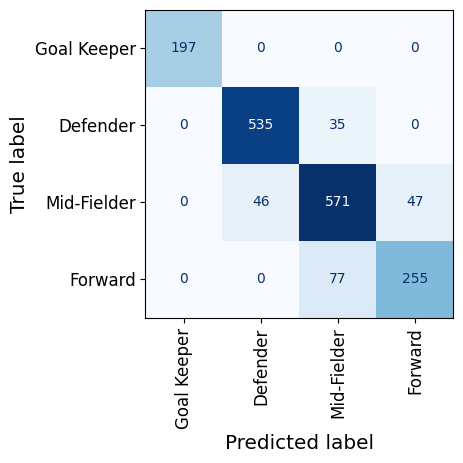

In [57]:
cm  = confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(y_pred, axis = 1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

plt.show();

In [58]:
loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy
54,0.276558,0.88562,0.284734,0.885423


# Assignment: S14-01

1. Implement L2 Regularization 
2. Change data set to Fashion MNIST 